In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

data_df = pd.read_csv('/content/drive/My Drive/ratings_Electronics.csv',  names=['userId', 'productId', 'ratings','timestamp'])

In [4]:
data_df.shape

(7824482, 4)

In [5]:
dataset = data_df.iloc[:,:-1]
dataset.shape # Ignoring the last columns holding timestamp values

(7824482, 3)

In [6]:
dataset.columns # Considering only the remaining three columns for analysis

Index(['userId', 'productId', 'ratings'], dtype='object')

In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


As observed 
1.   Mean, Median have different values.
2.   Mean is less than Median so its left skeiwed distribution



In [8]:
dataset.ratings.unique()#No missing values, Min value 1.0 and Max values 5.0

array([5., 1., 3., 2., 4.])

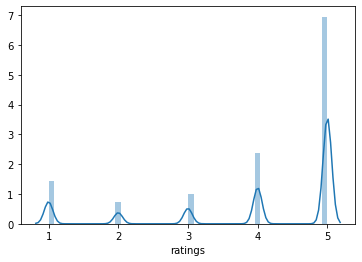

In [9]:
sns.distplot(dataset.ratings , hist=True)
#Seems most given rating is 5.0

In [11]:
ratcount = dataset['userId'].value_counts()
df = pd.DataFrame(ratcount) 
df = df[df['userId'] >= 50 ]
df.rename(columns={'userId' : 'count'}, inplace = True)
df['userId'] = df.index
data = dataset.merge(df, left_on='userId', right_on='userId')[dataset.columns]
data.shape

(125871, 3)

125k users have given ratings to more than 50 products in the large dataset.

In [12]:
data.userId.unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

IMPLEMENTING POPULATY BASED RECOMMENDATION SYSTEM

In [13]:
data.groupby('productId')['ratings'].mean().head()

productId
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: ratings, dtype: float64

In [14]:
data.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: ratings, dtype: float64

In [15]:
data.groupby('productId')['ratings'].count().head()

productId
0594451647    1
0594481813    1
0970407998    2
0972683275    4
1400501466    6
Name: ratings, dtype: int64

In [16]:
data.groupby('productId')['ratings'].count().sort_values(ascending=False).head()

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

In [17]:
ratings_mean_count = pd.DataFrame(data.groupby('productId')['ratings'].mean()) 
ratings_mean_count.shape

(48190, 1)

In [18]:
ratings_mean_count['ratings_count'] = pd.DataFrame(data.groupby('productId')['ratings'].count())
ratings_mean_count.shape

(48190, 2)

In [19]:
ratings_mean_count.head()

,ratings,ratings_count
productId,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [20]:
ratings_mean_count.sort_values(by= 'ratings_count',ascending=False).head(10)

,ratings,ratings_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149
B008DWCRQW,4.094891,137
B00829THK0,4.416058,137
B002R5AM7C,4.125000,128
B004CLYEDC,4.669492,118


Popularity based 10 most preferred and recommended products listed above

As seen the products are listed as per the highest count of been rated compared to rest of the products. As the name suggests popularity based RS the products are listed based on popularity and hence are not at all user preference based or customised as per user wish or preferences. 

COLLABORATIVE BASED RECOMMENDATION SYSTEM

In [21]:
pip install scikit-surprise

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678239 sha256=95410b2831b8e63430c8369e7ab6f84d0cc52c13978bcfdd97af5c4c4cf34a62
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
from surprise import KNNWithMeans
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [23]:
ratings_dict = {'userID': list(data.userId),
                'itemID': list(data.productId),
                'rating': list(data.ratings)}
df = pd.DataFrame(ratings_dict)
df.shape

(125871, 3)

In [0]:
reader = Reader(rating_scale=(1.0, 5.0))
loaded = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [0]:
sim_options = {
    "name": "pearson_baseline",
    "user_based": True,  # Compute  similarities between users
}
algo = KNNWithMeans(k=50, sim_options=sim_options)

In [0]:
trainset, testset = train_test_split(loaded, test_size=.15)

In [27]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
test_pred = algo.test(testset)

In [29]:
test_pred

[Prediction(uid='A30KPB2ILF6K6J', iid='B003ES5ZQE', r_ui=5.0, est=5.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3H6NNGCINPLEC', iid='B002HJ9Q66', r_ui=4.0, est=4.348837209302325, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ADKGE078JK8K7', iid='B000RNDUMA', r_ui=5.0, est=4.260987008131601, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2WW57XX2UVLM6', iid='B002HWJT1A', r_ui=4.0, est=4.246913580246914, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3AYSYSLHU26U9', iid='B0043D2ICS', r_ui=3.0, est=4.034591679506933, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1H55L0BLPCWYF', iid='B002ZJTUOG', r_ui=5.0, est=4.260987008131601, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AFM7FK7NFEKFZ', iid='B004YAYM06', r_ui=4.0, est=4.829268292682927, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(ui

In [30]:
accuracy.rmse(test_pred,verbose=True)

RMSE: 1.0596


1.0596366866375833

In [31]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.7742


0.7741784046001934

In [0]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

In [0]:
gs.fit(loaded)

In [34]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9887593745734473
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [0]:
from collections import defaultdict

In [0]:
def get_top3_recommendations(predictions, topN = 5):
     
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
     
    return top_recs

In [0]:
top3_recommendations = get_top3_recommendations(test_pred)

In [48]:
for uid, user_ratings in top3_recommendations.items():
  print(uid)
  for iid in user_ratings:
      print(iid)

A30KPB2ILF6K6J
('B003ES5ZQE', 5.0)
('B003DNS88M', 4.568293556467557)
('B00GJYRVXA', 4.392156862745098)
('B00B19D2AY', 4.392156862745098)
('B008UG6GCC', 4.392156862745098)
A3H6NNGCINPLEC
('B001G5ZTLS', 5.0)
('B001TOD7ME', 5.0)
('B00390JT1O', 4.812605325244355)
('B001VEIZY2', 4.7988372093023255)
('B0054L8N7M', 4.396456256921373)
ADKGE078JK8K7
('B005HSG3TC', 4.529411764705882)
('B0011Z44UA', 4.529411764705882)
('B000RNDUMA', 4.260987008131601)
('B0010C86FS', 4.260987008131601)
('B003FO0GAW', 4.260987008131601)
A2WW57XX2UVLM6
('B00CCIKJDG', 4.556687808262755)
('B004HW7KDC', 4.291612855693405)
('B001UOSOTO', 4.260987008131601)
('B002HWJT1A', 4.246913580246914)
('B001EJ52KY', 4.246913580246914)
A3AYSYSLHU26U9
('B001FA1NZK', 5.0)
('B0011ZK6PC', 5.0)
('B001A5FH9S', 4.944913168590081)
('B00CELZD8C', 4.941197383686638)
('B00DK2JQOQ', 4.7906229466979715)
A1H55L0BLPCWYF
('B000QUUFRW', 5.0)
('B005F25IL4', 4.795454545454546)
('B0046TJG1U', 4.795454545454546)
('B00B46XUQU', 4.795454545454546)
('B002Z

Above is a list of 5 recommendations per user. 

For the above given dataset have implemented two types of Recommendation system


1.   Popularity based RS
2.   Collaberative filtering based RS

As name suggestes Popularity based RS considers the popular products and very generic and not user preference specific. Suitable for users which do not have any preference data available with us.

For Collaberative filtering user item is recommendation based on user preferences for a certain types of items and hence are recommended to each user accordingly. 

Making the dataset less sparse was an idea to consider only users with ample ratinngs to study the likeliness of product.

